## TP2 - K-Means
INF8111 - Fouille de données, Automne 2023
### Membres de l'équipe
    - Nom_1 - Matricule_1
    - Nom_2 - Matricule_2
    - Nom_3 - Matricule_3

## Date et directives de remise
Vous remettrez ce fichier nommé TP2\_Nom_1-Nom_2-Nom_3.ipynb dans la boîte de remise sur Moodle.

**Date limite: 1 Novembre à 23:55**.

### 1. Introduction : K-means

L'algorithme *K-Means* est une technique de clustering utilisée en fouille de données qui permet le regroupement d'objets selon leur proximité. Ceci peut également faire apparaitre des structures plus globales et ainsi permettre une meilleure compréhension d'ensembles de données volumineux. Dans la suite de ce TP, nous appelerons *points* les données à regrouper et *centroïdes*, les barycentres de chaque groupe.

Cet algorithme sera / a été vu en cours lors de la $4^{ème}$ séance de ce cours. Pour rappel, une [illustration](https://blog.naver.com/PostView.naver?blogId=matthewwk6&logNo=223014835781) de son exécution vous est fournie ci-dessous, les étoiles représentant les centroïdes.

<img alt="A man moving his hands away from his forehead sideways, in a mind-explosion gesture. An overlaid animation enforces the explosion character" width="500" height="400" src="https://miro.medium.com/v2/resize:fit:1280/1*rwYaxuY-jeiVXH0fyqC_oA.gif">



Dans sa forme 'classique', cet algorithme nécéssite d'être initialisé avec un ensemble de k centroïdes. Or, ce choix a un impact important sur les performances et résultats de l'algorithme.
De plus, il n'y a aucune assurance sur la qualité du résultat ainsi que sur le temps éxecution.


Ainsi, une variante, appelée *K-Means++*, permet de limiter cet écueil en assurant une log(k)-approximation du résultat optimal ${z_k^{*}}$ de K-Means (i.e. ${z_k^{*}\leq log(k) z_k  }$).

#### Objectif

Votre objectif pour ce TP est de développer un algorithme K-Means++ pour effectuer du clustering sur un ensemble de *word embeddings*. Cependant, cette méthode de clustering sur de grands ensembles de données est un problème très intensif en calcul, ce qui rend presque impossible leur exécution sans système distribué. Par conséquent, pour exécuter votre algorithme, vous aurez accès à un cluster de *cloud computing* distribué avec des centaines de cœurs.

À cette fin, un algorithme **MapReduce** sera implémenté avec le framework [Apache Spark](http://spark.apache.org), un système informatique distribué rapide. En résumé, Spark est un framework open source conçu avec une méthodologie *scale-out* qui en fait un outil très puissant pour les programmeurs ou les développeurs d'applications pour effectuer un volume massif de calculs et de traitement de données dans des environnements distribués. Spark fournit des API de haut niveau qui facilitent la création d'applications parallèles sans avoir à se soucier de la façon dont votre code et vos données sont parallélisés / distribués par le cluster informatique. Spark fait tout pour vous.

Pour ce TP, vous aurez à utiliser (et vous familiariser) les méthodes PySpark suivantes (non-exhaustif) :

* *collect*
* *createDataFrame*
* *createOrReplaceTempView*
* *flatMap*
* *map*
* *mapValues*
* *mean*
* *reduce*
* *reduceByKey*
* *toPandas*
* *toDF*
* *values*

La mise en œuvre suivra l'algorithme de K-Means dévellopé dans cet [article](https://web.stanford.edu/~rezab/classes/cme323/S16/projects_reports/bodoia.pdf) par Max Bodia. Il est ainsi fortement recommandé de lire cet article pour comprendre le processus suivi dans ce TP. Les illustrations fournies dans les parties 2 et 3 illustrent le flux de travail de l'algorithme et doivent être utilisée pour consultation tout au long de ce TP. Les cases oranges représentent les entrées, les mauves les sorties. Chaque fonction a impémenter y est indiqué par une case bleue dont le format de sortie attendu est indiqué en dessous.**Toutes ces opérations sont expliquées en détail dans les sections suivantes.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

#### 1.1 Configuration de Spark

Spark fonctionne sur les systèmes Windows et UNIX (par exemple, Linux, Mac OS). Il est facile d'exécuter Spark localement sur une seule machine - tout ce dont vous avez besoin est d'avoir Java installé sur votre système PATH, ou la variable d'environnement JAVA_HOME pointant vers une installation Java. Il est obligatoire que le **JDK v8** soit installé sur votre système, car Spark ne prend actuellement en charge que cette version. Si ce n'est pas le cas, accédez à [la page Web de Java](https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) pour télécharger et installer une machine virtuelle Java. N'oubliez pas de définir la variable d'environnement JAVA_HOME pour utiliser JDK v8 si votre installation ne le fait pas automatiquement. Mise à jour 2022: Il est à noté que pour les systèmes d'exploitation de **Google Cloud, JDK v8 n'est pas disponible. Remplacer cela par la JDK 10 (default-jdk) permet également à Spark de fonctionner pour ce TP.**

L'interface entre Python et Spark se fait via **PySpark**, qui peut être installé en exécutant `pip install pyspark` ou configuré en suivant la séquence ci-dessous:

1. D'abord, allez sur http://spark.apache.org/downloads
2. Sélectionnez la dernière version de Spark et le package pré-construit pour Apache Hadoop 2.7
3. Cliquez pour télécharger **spark-2.4.5-bin-hadoop2.7.tgz** et décompressez-le dans le dossier de votre choix.
4. Ensuite, exportez les variables suivantes pour lier PYSPARK (l'interface python de Spark) à votre distribution python dans votre fichier `~/.bash_profile`.

``
export SPARK_HOME=/chemin/ vers / spark-2.4.5-bin-hadoop2.7
export PYTHONPATH="$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.7-src.zip:$SPARK_HOME/python/lib/pyspark.zip:$ PYTHONPATH"
export PYSPARK_PYTHON=/chemin/vers/votre/python3
``

5. Exécutez `source ~./bash_profile` pour effectuer les modifications et redémarrer cette session de notebook jupyter.

#### Alternative pour Google Colab

Si vous utilisez Google Colaboratory, exécutez la cellule de code suivante pour installer Spark

In [2]:
import os
!apt install -y default-jdk
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
!pip install pyspark

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
default-jdk is already the newest version (2:1.11-72).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


#### Testez votre Spark / Test your Spark
À l'aide du code suivant, vous pouvez tester si Spark est correctement installé.

In [3]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'spark' as hello ")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



### 2. Implémentation K-MEANS (11.5 pts)

Le flot d'exécution d'une itération que vous allez implémenter pour KMEANS peut être schématisé de la manière suivante :

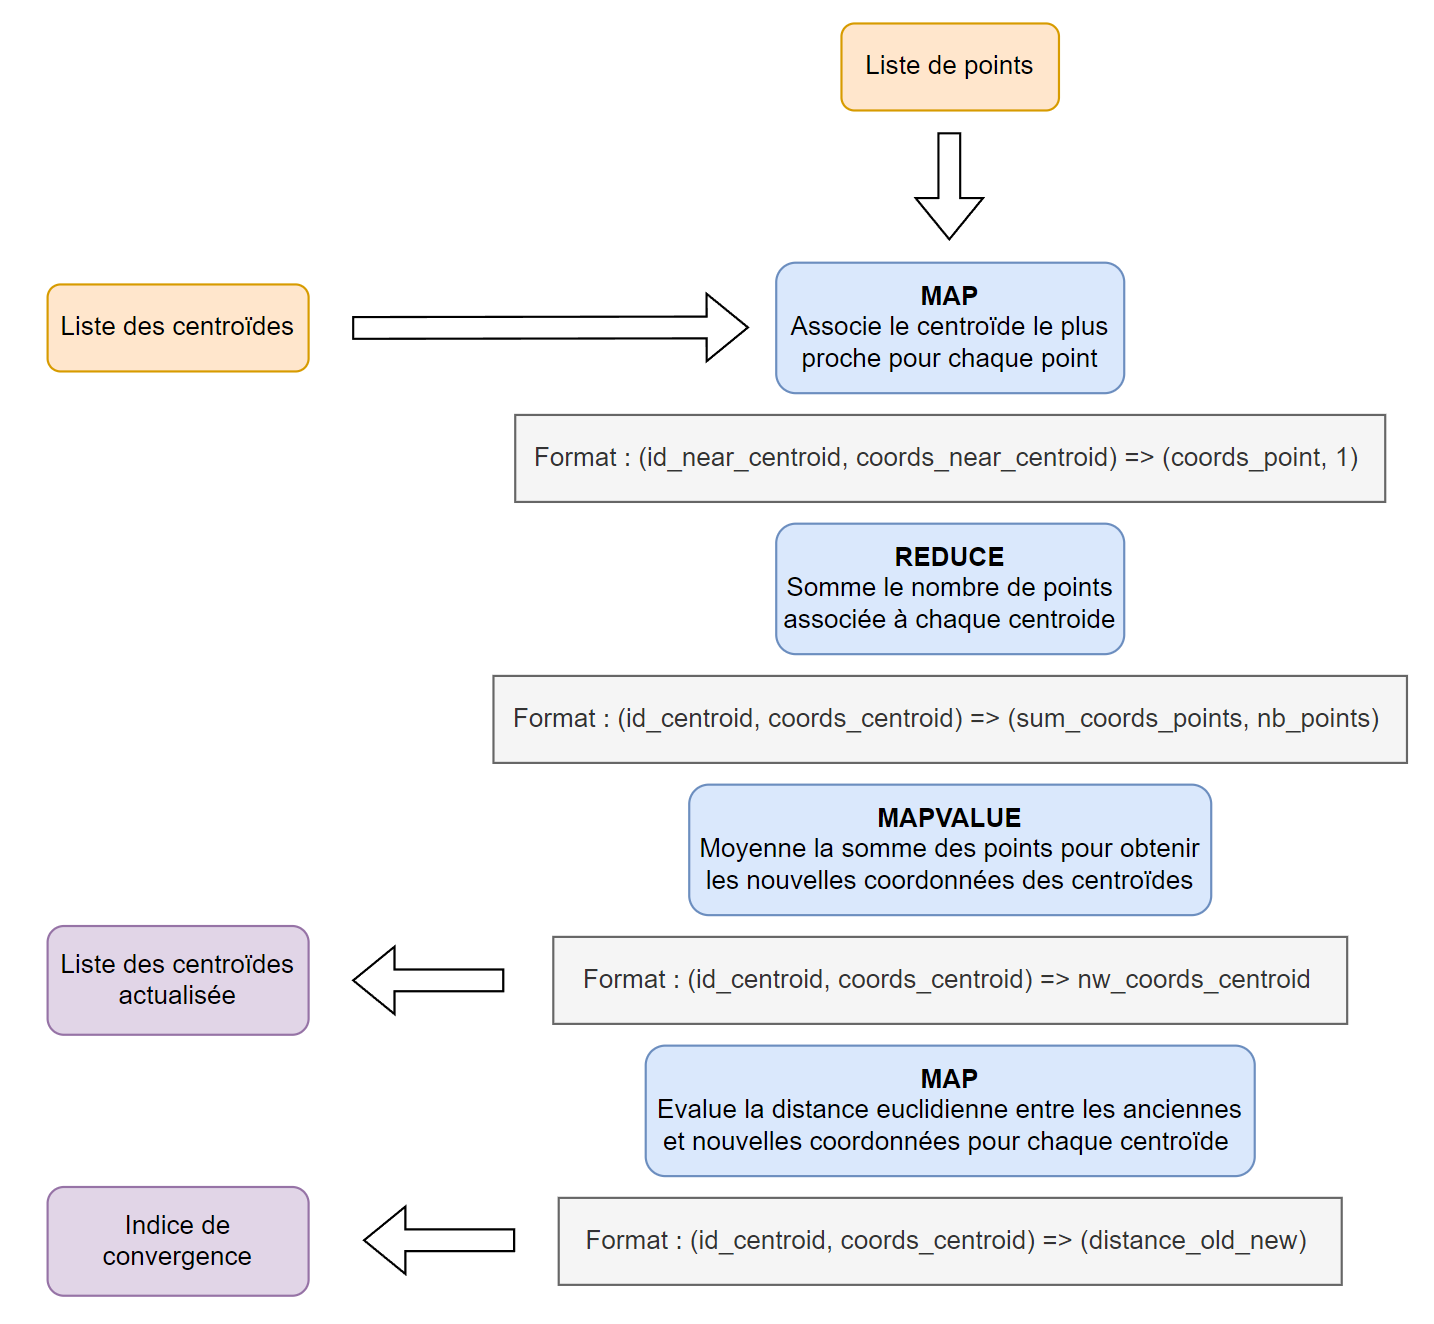

#### 2.1 Initialisation du dataframe PySpark

Dans cette première partie du TP, vous pourrez tester vos algorithmes avec les données suivantes. Vous pourrez ainsi comparer la sortie avec celle attendue. Ne modifiez pas la cellule suivante, elle sera utilisée pour la correction.

In [4]:
example_data = [[0.725, 0.042, 0.13], [0.187, 0.414, 0.74], [0.27, 0.054, 0.68], [0.076, 0.031, 0.681], [0.867, 0.06, 0.596], [0.464, 0.981, 0.021], [0.108, 0.695, 0.329], [0.952, 0.561, 0.213], [0.128, 0.189, 0.851], [0.972, 0.528, 0.737], [0.111, 0.804, 0.795], [0.447, 0.873, 0.008], [0.937, 0.346, 0.784], [0.677, 0.072, 0.587], [0.986, 0.543, 0.941], [0.382, 0.563, 0.179], [0.73, 0.84, 0.967], [0.251, 0.072, 0.002], [0.065, 0.633, 0.627], [0.141, 0.737, 0.058], [0.611, 0.723, 0.738], [0.664, 0.281, 0.425], [0.048, 0.539, 0.455], [0.997, 0.533, 0.757], [0.756, 0.04, 0.389], [0.738, 0.582, 0.509], [0.765, 0.936, 0.241], [0.16, 0.587, 0.903], [0.118, 0.312, 0.858], [0.142, 0.28, 0.426], [0.323, 0.932, 0.612], [0.559, 0.936, 0.742], [0.789, 0.396, 0.25], [0.669, 0.61, 0.906], [0.836, 0.089, 0.751], [0.854, 0.02, 0.798], [0.223, 0.088, 0.616], [0.736, 0.161, 0.437], [0.232, 0.998, 0.672], [0.011, 0.973, 0.953], [0.886, 0.204, 0.348], [0.821, 0.388, 0.278], [0.483, 0.133, 0.123], [0.666, 0.481, 0.019], [0.85, 0.215, 0.806], [0.331, 0.11, 0.156], [0.63, 0.369, 0.004]]
example_centroids = [[0.725, 0.042, 0.13], [0.187, 0.414, 0.74], [0.27, 0.054, 0.68]]

spark = SparkSession.builder.getOrCreate()
df_example_points = spark.createDataFrame(pd.DataFrame({"data": example_data}))
rdd_example_points = df_example_points.rdd

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:1px">
<code>
+---------------------+
|points               |
+---------------------+
|[0.725, 0.042, 0.13] |
|[0.187, 0.414, 0.74] |
|[0.27, 0.054, 0.68]  |
|[0.076, 0.031, 0.681]|
|[0.867, 0.06, 0.596] |
|[0.464, 0.981, 0.021]|
|[0.108, 0.695, 0.329]|
|[0.952, 0.561, 0.213]|
|[0.128, 0.189, 0.851]|
|[0.972, 0.528, 0.737]|
|[0.111, 0.804, 0.795]|
|[0.447, 0.873, 0.008]|
|[0.937, 0.346, 0.784]|
|[0.677, 0.072, 0.587]|
|[0.986, 0.543, 0.941]|
|[0.382, 0.563, 0.179]|
|[0.73, 0.84, 0.967]  |
|[0.251, 0.072, 0.002]|
|[0.065, 0.633, 0.627]|
|[0.141, 0.737, 0.058]|
+---------------------+
only showing top 20 rows
</code>
</pre>

Vous devriez obtenir la sortie ci-dessus à l'exécution de la cellule suivante :

In [5]:
rdd_example_points.toDF(['points']).show(truncate=False)

+---------------------+
|points               |
+---------------------+
|[0.725, 0.042, 0.13] |
|[0.187, 0.414, 0.74] |
|[0.27, 0.054, 0.68]  |
|[0.076, 0.031, 0.681]|
|[0.867, 0.06, 0.596] |
|[0.464, 0.981, 0.021]|
|[0.108, 0.695, 0.329]|
|[0.952, 0.561, 0.213]|
|[0.128, 0.189, 0.851]|
|[0.972, 0.528, 0.737]|
|[0.111, 0.804, 0.795]|
|[0.447, 0.873, 0.008]|
|[0.937, 0.346, 0.784]|
|[0.677, 0.072, 0.587]|
|[0.986, 0.543, 0.941]|
|[0.382, 0.563, 0.179]|
|[0.73, 0.84, 0.967]  |
|[0.251, 0.072, 0.002]|
|[0.065, 0.633, 0.627]|
|[0.141, 0.737, 0.058]|
+---------------------+
only showing top 20 rows



#### 2.2 Implémentation du Map (2pts)

Implémentez la fonction **mapRegroup** qui détermine le plus proche centroïde pour chaque point de l'ensemble. On concidera la distanxce Avec notre ensemble de données, la sortie attendue est similaire à :

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:1px">
<code>
+-------------------------+--------------------------+
|nearest centroid         |points                    |
+-------------------------+--------------------------+
|{0, {0.725, 0.042, 0.13}}|{[0.725, 0.042, 0.13], 1} |
|{1, {0.187, 0.414, 0.74}}|{[0.187, 0.414, 0.74], 1} |
|{2, {0.27, 0.054, 0.68}} |{[0.27, 0.054, 0.68], 1}  |
|{2, {0.27, 0.054, 0.68}} |{[0.076, 0.031, 0.681], 1}|
|{0, {0.725, 0.042, 0.13}}|{[0.867, 0.06, 0.596], 1} |
|{1, {0.187, 0.414, 0.74}}|{[0.464, 0.981, 0.021], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.108, 0.695, 0.329], 1}|
|{0, {0.725, 0.042, 0.13}}|{[0.952, 0.561, 0.213], 1}|
|{2, {0.27, 0.054, 0.68}} |{[0.128, 0.189, 0.851], 1}|
|{0, {0.725, 0.042, 0.13}}|{[0.972, 0.528, 0.737], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.111, 0.804, 0.795], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.447, 0.873, 0.008], 1}|
|{2, {0.27, 0.054, 0.68}} |{[0.937, 0.346, 0.784], 1}|
|{2, {0.27, 0.054, 0.68}} |{[0.677, 0.072, 0.587], 1}|
|{2, {0.27, 0.054, 0.68}} |{[0.986, 0.543, 0.941], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.382, 0.563, 0.179], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.73, 0.84, 0.967], 1}  |
|{0, {0.725, 0.042, 0.13}}|{[0.251, 0.072, 0.002], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.065, 0.633, 0.627], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.141, 0.737, 0.058], 1}|
+-------------------------+--------------------------+
only showing top 20 rows

</code>
</pre>

In [6]:
import numpy as np

def distance(point, centroid):
    return np.linalg.norm(point - centroid)

In [7]:
from pyspark.sql import Row

def mapRegroup(row, centroids):
    result = []
    pt= row
    min_distance = float('inf')
    nearest_centroid_index = None

    for i, centroid in enumerate(centroids):
        p = np.array(pt)
        centroid = np.array(centroid)

        # Distance entre le point et le centroïde.
        dist = distance(p, centroid)

        if dist < min_distance:
            min_distance = dist
            nearest_centroid_index = i

    # Ajoute le point et l'index du centroïde le plus proche au résultat.
    result.append(((nearest_centroid_index, tuple(centroids[nearest_centroid_index])), (p.tolist()[0],1)))

    return result

In [8]:
rdd_nearest_means = rdd_example_points.flatMap(lambda x : mapRegroup(x, example_centroids))
rdd_nearest_means.toDF(['nearest centroid', 'point']).show(truncate=False)

+-------------------------+--------------------------+
|nearest centroid         |point                     |
+-------------------------+--------------------------+
|{0, {0.725, 0.042, 0.13}}|{[0.725, 0.042, 0.13], 1} |
|{1, {0.187, 0.414, 0.74}}|{[0.187, 0.414, 0.74], 1} |
|{2, {0.27, 0.054, 0.68}} |{[0.27, 0.054, 0.68], 1}  |
|{2, {0.27, 0.054, 0.68}} |{[0.076, 0.031, 0.681], 1}|
|{0, {0.725, 0.042, 0.13}}|{[0.867, 0.06, 0.596], 1} |
|{1, {0.187, 0.414, 0.74}}|{[0.464, 0.981, 0.021], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.108, 0.695, 0.329], 1}|
|{0, {0.725, 0.042, 0.13}}|{[0.952, 0.561, 0.213], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.128, 0.189, 0.851], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.972, 0.528, 0.737], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.111, 0.804, 0.795], 1}|
|{0, {0.725, 0.042, 0.13}}|{[0.447, 0.873, 0.008], 1}|
|{2, {0.27, 0.054, 0.68}} |{[0.937, 0.346, 0.784], 1}|
|{2, {0.27, 0.054, 0.68}} |{[0.677, 0.072, 0.587], 1}|
|{1, {0.187, 0.414, 0.74}}|{[0.986, 0.543, 0.941], 1}|
|{1, {0.18

#### 2.3 Implémentation du Reduce (1pt)

Implémentez la fonction **reduceMeans** qui doit additionner les coordonnées de chaque point ainsi que le nombre de points, liés à un même centroïde. Pour notre ensemble de données, la sortie attendue est similaire à :

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:1px">
<code>
+-------------------------+-----------------------------------------+
|nearest centroid         |partial new centroid                     |
+-------------------------+-----------------------------------------+
|{1, {0.187, 0.414, 0.74}}|{[6.246, 14.012, 11.498000000000001], 20}|
|{0, {0.725, 0.042, 0.13}}|{[12.291, 5.295, 5.1049999999999995], 17}|
|{2, {0.27, 0.054, 0.68}} |{[5.837, 1.6469999999999998, 7.495], 10} |
+-------------------------+-----------------------------------------+
</code>
</pre>

In [9]:
def reduceMeans(point_1, point_2):

    ([x1,y1,z1],s1) = point_1
    ([x2,y2,z2], s2) = point_2

    x_sum = x1 + x2
    y_sum = y1 + y2
    z_sum = z1 + z2
    s_sum=s1+s2


    return ([x_sum,y_sum, z_sum], s_sum)

In [10]:
rdd_nw_means = rdd_nearest_means.reduceByKey(reduceMeans)
rdd_nw_means.toDF(['nearest centroid', 'partial new centroid']).show(truncate=False)

+-------------------------+-----------------------------------------------------+
|nearest centroid         |partial new centroid                                 |
+-------------------------+-----------------------------------------------------+
|{1, {0.187, 0.414, 0.74}}|{[8.882000000000001, 14.932, 14.776000000000003], 23}|
|{0, {0.725, 0.042, 0.13}}|{[10.769, 5.107, 3.619], 16}                         |
|{2, {0.27, 0.054, 0.68}} |{[4.723, 0.9149999999999999, 5.702999999999999], 8}  |
+-------------------------+-----------------------------------------------------+



Implémentez la fonction **computeMeans** qui calcule les nouvelles coordonnées des centroïdes à partir du couple (coordonnées additionnées, nombre de points additionnés). Pour notre ensemble de données, la sortie attendue est similaire à :

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:1px">
<code>
+-------------------------+-----------------------------------------------+
|nearest centroid         |new centroid                                   |
+-------------------------+-----------------------------------------------+
|{1, {0.187, 0.414, 0.74}}|[0.3123, 0.7006, 0.5749000000000001]           |
|{0, {0.725, 0.042, 0.13}}|[0.723, 0.3114705882352941, 0.3002941176470588]|
|{2, {0.27, 0.054, 0.68}} |[0.5837, 0.16469999999999999, 0.7495]          |
+-------------------------+-----------------------------------------------+
</code>
</pre>

In [11]:
def computeMeans(centroid):
    (coords_sum, count) = centroid
    new_coords = [x / count for x in coords_sum]
    return new_coords

In [12]:
rdd_means = rdd_nw_means.mapValues(computeMeans)
rdd_means.toDF(['nearest centroid', 'new centroid']).show(truncate=False)

+-------------------------+------------------------------------------------------------+
|nearest centroid         |new centroid                                                |
+-------------------------+------------------------------------------------------------+
|{1, {0.187, 0.414, 0.74}}|[0.3861739130434783, 0.6492173913043479, 0.6424347826086958]|
|{0, {0.725, 0.042, 0.13}}|[0.6730625, 0.3191875, 0.2261875]                           |
|{2, {0.27, 0.054, 0.68}} |[0.590375, 0.11437499999999999, 0.7128749999999999]         |
+-------------------------+------------------------------------------------------------+



#### 2.4 Convergence (2.5pt)

Implémentez la fonction **mapConvergence** qui calcule la cosinus distance euclidienne entre l'ancienne et la nouvelle position de chaque centroïde.
Pour cela, définissez la fonction **distance_cosinus** avec l'équation suivante : $dist\_cos(x, y) = 1 - \frac{ \sum_i x_i y_i}{ \sqrt{\sum_i x_i^2 \sum_j y_j^2 }}$


In [13]:
def distance_cosinus(point_1, point_2):

    dot_product = np.dot(point_1, point_2)

    norm_1 = np.linalg.norm(point_1)
    norm_2 = np.linalg.norm(point_2)

    cosine_distance = 1.0 - (dot_product / (norm_1 * norm_2))

    return cosine_distance


In [14]:
def mapConvergence(point):
    ((centroid_key, old_coordinates), new_centroid) = point
    distance = distance_cosinus(list(old_coordinates), new_centroid)
    return [1,distance]


In [15]:
# indice de convergence
rdd_conv = rdd_means.map(mapConvergence).values().mean()

In [16]:
rdd_conv

0.059074904094360225

#### 2.5 Récapitulatif (6 pts)

##### 2.5.1 Implémentation (1 pt)

Implémentez la fonction **iteration_kmeans** qui réalise une itération de l'algorithme K-Means. Celle-ci doit réutiliser les fonctions définies dans les parties précédentes. Elle doit également retourner l'indice de convergence courant et la liste des centroides avec leurs coordonnées actualisées.

In [17]:
def iteration_kmeans(points, centroids):

    rdd_nearest_means = points.flatMap(lambda x: mapRegroup(x, centroids))

    rdd_nw_means = rdd_nearest_means.reduceByKey(reduceMeans)

    rdd_means = rdd_nw_means.mapValues(computeMeans)

    rdd_conv = rdd_means.map(mapConvergence).values().mean()


    new_centroids = rdd_means.map(lambda item: (item[1])).collect()

    return rdd_conv, new_centroids


##### 2.5.2 Exécution (1.5 pt)

Vous devez exécuter l'ensemble de l'agorithme sur le jeu de données généré ci-dessous. Cette exécution nécéssite donc de définir un critère de convergence. On considère ici la convergence de la position des points (évaluée par la fonction **mapConvergence**) comme critère de convergence global avec un seuil à $10^{-5}$.

In [18]:
data_points = []
for i in range(1000):
    data_points.append([random.uniform(0, 0.5), random.uniform(0, 0.5), random.uniform(0, 1)])
    data_points.append([random.uniform(0.5, 1), random.uniform(0, 0.5), random.uniform(0.5, 1)])
    data_points.append([random.uniform(0.5, 1), random.uniform(0.5, 1), random.uniform(0, 0.5)])
    data_points.append([random.uniform(0, 0.5), random.uniform(0.5, 1), random.uniform(0.5, 1)])

# On considère ici les 4 premiers points comme les centroïdes initiaux
data_centroids_init = [data_points[0], data_points[1], data_points[2],  data_points[3]]

spark = SparkSession.builder.getOrCreate()
df_rand = spark.createDataFrame(pd.DataFrame({"data": data_points}))
rdd_rand = df_rand.rdd

In [19]:
# A implémenter
# Seuil de convergence
seuil_convergence = 1e-5

# Initialisation des variables
centroids = data_centroids_init
convergence = float('inf')
iteration = 0

while convergence > seuil_convergence:
    convergence, centroids = iteration_kmeans(rdd_rand, centroids)
    iteration += 1
    print(f"Iteration {iteration}: Convergence = {convergence}")

# Affichage des résultats finaux
print("Résultats finaux :")
for i, centroid in enumerate(centroids):
    print(f"Centroïde {i}: {centroid}")


Iteration 1: Convergence = 0.05164799066436607
Iteration 2: Convergence = 0.001369767100615732
Iteration 3: Convergence = 0.00014043740384106496
Iteration 4: Convergence = 4.865735790898773e-05
Iteration 5: Convergence = 2.4561099933262387e-05
Iteration 6: Convergence = 9.937301682860777e-06
Résultats finaux :
Centroïde 0: [0.24153596661223548, 0.23168191098835358, 0.3977232776826394]
Centroïde 1: [0.7085156759598911, 0.24308860289286766, 0.7607801485651281]
Centroïde 2: [0.752453302404174, 0.7458710063306885, 0.25397768289064343]
Centroïde 3: [0.2508235503377663, 0.720821829308726, 0.7586234150714162]


##### 2.5.3 Représentation visuelle (1.5 pt)

Complétez le code suivant afin d'obtenir une représentation tridimensionnelle du clustering effectué par l'algorithme. Chaque cluster devra être identifié par une couleur unique. Vous pourrez ici utiliser la methode *flatMap* et *collect* pour extraire les coordonnées des points.



In [20]:
# A implémenter
result = rdd_rand.flatMap(lambda x: mapRegroup(x, centroids))
lab = result.map(lambda x : [x[0][0], x[1][0][0], x[1][0][1], x[1][0][2] ])
df = pd.DataFrame(lab.collect(), columns = ['center', 'x1', 'x2', 'x3'])

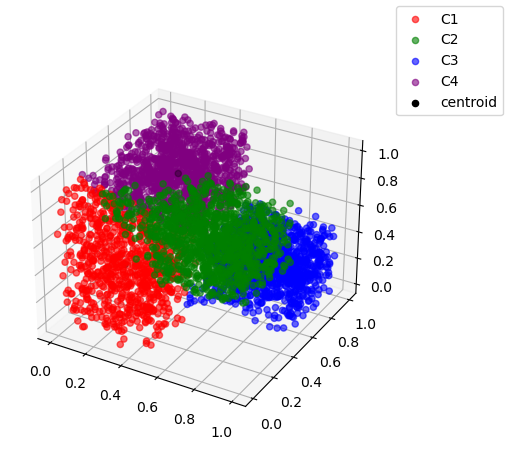

In [21]:
# A implémenter
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
centr = np.array(centroids)
color = ['red', 'green', 'blue', 'purple']
for i in range(4):
  cluster = df[df['center'] == i]
  ax.scatter(cluster['x1'], cluster['x2'], cluster['x3'], c=color[i], label="C" + str(i+1) , alpha = 0.6) #descendre le alpha à 0.1 pour observer les centroids
ax.scatter(centr[:, 0], centr[:, 1], centr[:, 2], c='black', label = 'centroid' )
fig.legend();

##### 2.5.4 Taille des clusters (2 pts)

Quelle est la taille de chaque cluster ? Représentez l'ensemble des résultats dans un bar-plot à l'aide de SQL ou de l'API Spark.

In [22]:
# A implémenter
tailles = []
for i in range(4):
  cluster = df[df['center'] == i]
  tailles.append(cluster.shape[0])
print('tailles = ' , tailles)
print('on retrouve bien notre total de points : ', sum(tailles))

tailles =  [764, 1124, 1006, 1106]
on retrouve bien notre total de points :  4000


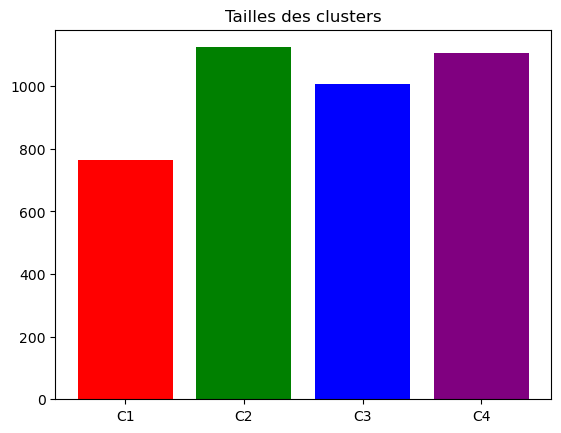

In [23]:
plt.bar(range(1, 5), tailles, color = color)
plt.title('Tailles des clusters');
plt.xticks(range(1, 5), ['C1', 'C2', 'C3', 'C4']);

### 3. Implémentation K-MEANS++ (6.5 pts)

#### 3.1 Principe

Différentes versions de K-Means existent, afin d'améliorer ces performances. Certaines jouent sur le choix des centroïdes initiaux. En effet, il existe différentes manières pour les initialiser. Ils peuvent être pris aléatoirement (uniformément) parmi l'ensemble des points, comme ce fût le cas dans la deuxième partie. Néanmoins, cette méthode ne possède aucune assurance quant à l'optimalité des clusters obtenus. Une seconde approche, nommée K-Means++, consiste à pondérer, non-uniformément, la probabilité de choisir un point des données. Son implémentation constitue la partie 3 de ce TP.

Le flot d'exécution d'une itération peut être résumé de la façon suivante :

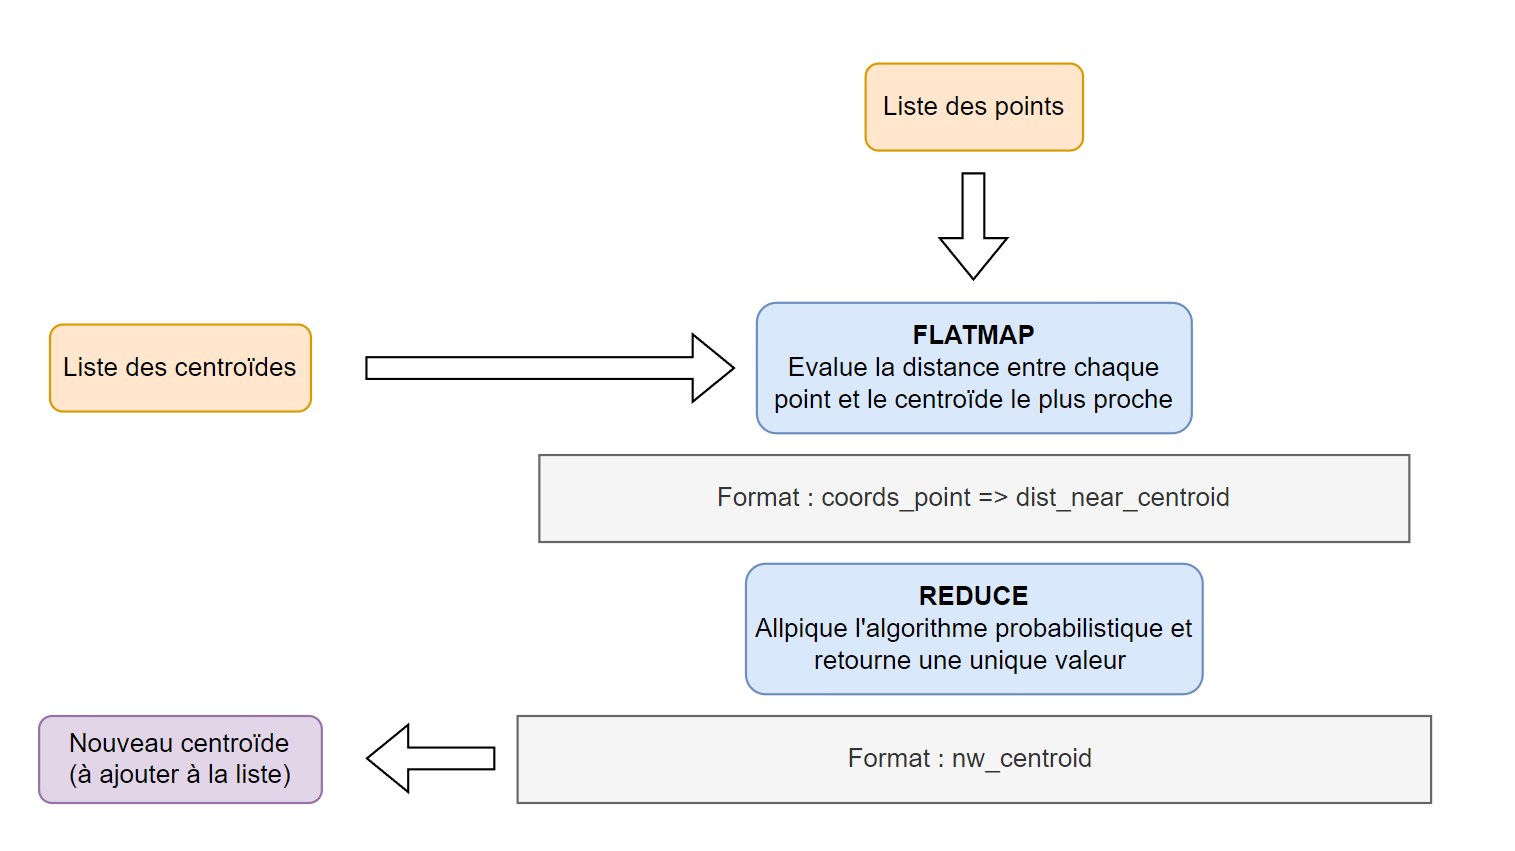

#### 3.2 Implémentation du Map (2 pts)

In [24]:
example_centroids = [example_data[2]]

spark = SparkSession.builder.getOrCreate()
df_points = spark.createDataFrame(pd.DataFrame({"data": example_data}))
rdd_points = df_points.rdd

Implémentez la fonction **mapDistance**. Celle-ci évalue la plus courte distance (selon la cosinus-distance) à un centroïde pour un point $x$ donné. Elle doit donc évaluer l'expression suivante : ${min}_{c \in C} \{ \sum_i (x_i - c_i)^2 \}$ où $C$ représente la liste de
 centroïdes.

In [25]:
def cosine_distance(x, c):
        dot_product = np.dot(x, c)
        norm_x = np.linalg.norm(x)
        norm_c = np.linalg.norm(c)
        return 1.0 - (dot_product / (norm_x * norm_c))

In [26]:
def mapDistance(point, centroids):

    distances = [cosine_distance(point, centroid) for centroid in centroids]
    min_distance = min(distances)
    return [(point,float(min_distance))]

L'éxécution de la cellule suivante devra produire une sortie similaire à celle-ci :

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:1px">
<code>
+--------------------+--------------------+
|               point|            distance|
+--------------------+--------------------+
|[0.725, 0.042, 0.13]|  0.4708153636011032|
|[0.187, 0.414, 0.74]| 0.09571928250016315|
| [0.27, 0.054, 0.68]|                 0.0|
|[0.076, 0.031, 0....|0.035660779254765185|
|[0.867, 0.06, 0.596]|  0.1687935238050169|
|[0.464, 0.981, 0....|  0.7582099516253307|
|[0.108, 0.695, 0....|  0.4902000155515207|
|[0.952, 0.561, 0....| 0.47652504104761795|
|[0.128, 0.189, 0....|0.035495919498101935|
|[0.972, 0.528, 0....| 0.18768899253367188|
|[0.111, 0.804, 0....|  0.2633569754484292|
|[0.447, 0.873, 0....|  0.7591968860598073|
|[0.937, 0.346, 0....|  0.1360711462948938|
|[0.677, 0.072, 0....|  0.1116757459665162|
|[0.986, 0.543, 0....| 0.13092936725117998|
|[0.382, 0.563, 0....|  0.5054226526033345|
| [0.73, 0.84, 0.967]| 0.16788156345370786|
|[0.251, 0.072, 0....|  0.6188512758606007|
|[0.065, 0.633, 0....| 0.27050884880524984|
|[0.141, 0.737, 0....|   0.787537474881876|
+--------------------+--------------------+
only showing top 20 rows
</code>
</pre>

In [27]:
rdd_nearest_centroid = rdd_points.flatMap(lambda x : mapDistance(x, example_centroids))
rdd_nearest_centroid.toDF(['point', 'distance']).show()

+--------------------+--------------------+
|               point|            distance|
+--------------------+--------------------+
|{[0.725, 0.042, 0...|  0.4708153636011032|
|{[0.187, 0.414, 0...| 0.09571928250016315|
|{[0.27, 0.054, 0....|                 0.0|
|{[0.076, 0.031, 0...|0.035660779254765185|
|{[0.867, 0.06, 0....|  0.1687935238050169|
|{[0.464, 0.981, 0...|  0.7582099516253307|
|{[0.108, 0.695, 0...|  0.4902000155515207|
|{[0.952, 0.561, 0...| 0.47652504104761795|
|{[0.128, 0.189, 0...|0.035495919498101935|
|{[0.972, 0.528, 0...| 0.18768899253367177|
|{[0.111, 0.804, 0...| 0.26335697544842906|
|{[0.447, 0.873, 0...|  0.7591968860598073|
|{[0.937, 0.346, 0...|  0.1360711462948938|
|{[0.677, 0.072, 0...| 0.11167574596651597|
|{[0.986, 0.543, 0...| 0.13092936725117998|
|{[0.382, 0.563, 0...|  0.5054226526033345|
|{[0.73, 0.84, 0.9...| 0.16788156345370786|
|{[0.251, 0.072, 0...|  0.6188512758606007|
|{[0.065, 0.633, 0...|  0.2705088488052497|
|{[0.141, 0.737, 0...|  0.787537

#### 3.3 Implémentation du Reduce (2 pts)

Implémentez la fonction **reduceKeyProb**. Elle devra implémenter l'algorithme suivant (pour plus de détails, se référer à l'article de référence) :

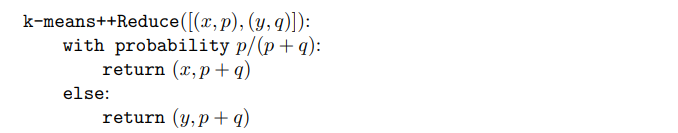

Son éxécution devra retourner un nouveau centroïde.

In [28]:
def reduceKeyProb(point_1, point_2):
    x, p = point_1
    y, q = point_2

    probability = p / (p + q)

    if probability > 0.5:
        new_point = x
        new_probability = p + q
    else:
        new_point = y
        new_probability = p + q

    return (new_point, new_probability)

In [29]:
nw_centroid = rdd_nearest_centroid.reduce(reduceKeyProb)

#### 3.4 Récapitulatif (2.5 pts)

##### 3.4.1 Implémentation (1 pt)

Implémentez la fonction **iteration_init_kmeans**. Elle doit effetuer une itération complète de l'algorithme d'initialisation de K-MEANS++ présentée dans cette partie. Elle doit ainsi ajouter un centroïde à la liste *centroids* et retourner cette nouvelle liste.

In [30]:
def distance_to_nearest_centroid(point, centroids):
    min_distance = float('inf')
    for centroid in centroids:
        distance = np.linalg.norm(np.array(point) - np.array(centroid))
        min_distance = min(min_distance, distance)
    return min_distance


In [31]:
import numpy as np

def choose_next_centroid(data_points, centroids):
    data_points_array = np.array(data_points.collect())

    centroids_array = np.array(centroids)  
    squared_distances = []

    for point in data_points_array:
        min_distance = np.inf
        for centroid in centroids_array:
            distance = np.linalg.norm(point - centroid)  
            min_distance = min(min_distance, distance)
        squared_distances.append(min_distance ** 2)

    total_distance = sum(squared_distances)
    normalized_probabilities = [dist / total_distance for dist in squared_distances]


    next_centroid_index = np.random.choice(len(data_points_array), size=1, p=normalized_probabilities).item()
    next_centroid = data_points_array[next_centroid_index]
    return next_centroid.tolist()[0]


In [32]:
def iteration_init_kmeans(rdd_points, centroids):
    next_centroid = choose_next_centroid(rdd_points, centroids)
    centroids.append(next_centroid)
    return centroids

##### 3.4.2 Exécution (1.5 pt)

Complétez la seconde cellule afin de pouvoir exécuter cette cellule sur GCP. Elle doit implémenter l'algorithme K-MEANS++ au complet (dont l'initialisation).

In [33]:
data_points = []
for i in range(10000):
    data_points.append([random.random(), random.random(), random.random()])

spark = SparkSession.builder.getOrCreate()
df_points = spark.createDataFrame(pd.DataFrame({"data": data_points}))
rdd_points = df_points.rdd

centroids = [data_points[random.randint(0, len(data_points))]]

In [34]:
k=10
for _ in range(1, k):
  centroids = iteration_init_kmeans(rdd_points, centroids)

# Affichage des centroïdes
for i, centroid in enumerate(centroids):
    print(f"Centroid {i+1}: {centroid}")

Centroid 1: [0.3195072088769686, 0.8833069771311064, 0.7607981411208186]
Centroid 2: [0.6448995548607386, 0.06400465308856707, 0.7119231793858825]
Centroid 3: [0.6542719904553431, 0.7681355084131769, 0.32081621393453164]
Centroid 4: [0.7775266582985609, 0.6848947223823411, 0.7306767487472399]
Centroid 5: [0.07770199236497366, 0.6457471646286205, 0.22423398984869036]
Centroid 6: [0.4635025693374324, 0.46883563956494456, 0.6615120952975727]
Centroid 7: [0.07087419201294864, 0.8454582980539985, 0.5373546771125672]
Centroid 8: [0.09527243811201336, 0.19422556476072395, 0.9933243948286342]
Centroid 9: [0.8979825827045073, 0.38237642666511196, 0.6226816835340114]
Centroid 10: [0.3638887741184206, 0.09546103291968888, 0.8463069070075628]


### 4. GCP (7 pts)

Jusqu'à présent, le code était exécuté sur un faible nombre de points (de faible dimension). Dans cette sous-partie, vous allez utiliser l'algorithme K-MEANS++ sur quelques milliers de points de dimension 500. La suite de ce TP devra donc être exécutée sur Google Cloud Platform (GCP). Pour cela, vous pouvez créer un second notebook contenant uniquement le code nécessaire à cette partie. Le paramétrage de cette plateforme est détaillé dans le fichier *Instructions_GCP.pdf*.

Lors de la soumission de ce TP, vous ajouterez aussi différentes captures d'écran concernant le paramétrage de GCP.

#### 4.1 Chargement des données

In [35]:
import random

La cellule suivante charge le fichier *model.bin* (disponible sur Moodle) contenant la représentation vectorielle d'un ensemble de mots. Il 'agit d'un sous-ensemble extrait du modèle [*frWac_no_postag_phrase_500_cbow_cut10*](http://fauconnier.github.io/). La structure *vocabulary* contient ainsi l'ensemble des mots contenus dans notre fichier.

In [36]:
!pip install gensim

In [37]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("gs://tp2_my_bucket1/model.bin", binary=True, unicode_errors='replace')
vocabulary = model.index_to_key

In [38]:
subvoc = random.sample(vocabulary, 2000) # A ajuster selon le temps

In [39]:
points = []
points_mots=[] #j'ai créé cela pour avoir accès aux mots facilement
for item in subvoc:
    points.append(model[item].tolist())
    points_mots.append(item)

#### 4.2 Implémentation (2 pts)

In [40]:
spark = SparkSession.builder.getOrCreate()
df_points = spark.createDataFrame(pd.DataFrame({"data": points}))
rdd_points = df_points.rdd

In [ ]:
k = 50
centroids = [points[random.randint(0, len(points))]]
for _ in range(1, k):
  centroids = iteration_init_kmeans(rdd_points, centroids)


#### 4.3 Exécution (4 pts)

Pour cette exécution, vous remettrez un ficher .txt contenant l'ensemble des clusters ayant entre 2 et 20 mots. Ce ficher devra donc uniquement contenir des mots (en français) et non leur représentation vectorielle. Vous remettrez également différentes captures d'écran attestant de l'exécution de ce dernier. Le code utilisé devra être le même que celui contenu dans la cellule suivante.

In [ ]:
clusters = [[] for _ in range(k)]  # Listes vides pour chaque cluster, contient les valeurs vectorielles
cluster_words=[[] for _ in range(k)] #Notre liste de mots, contient les mots

for point in points_mots:
    distances = [np.linalg.norm(model[point] - np.array(centroid)) for centroid in centroids]

    closest_cluster = np.argmin(distances)

    clusters[closest_cluster].append(model[point])
    cluster_words[closest_cluster].append(point)

filtered_clusters = [cluster for cluster in cluster_words if 2 <= len(cluster) <= 20]

with open("clusters.txt", "w") as file:
    for i, cluster in enumerate(filtered_clusters):
        file.write(f"Cluster {i + 1}:\n")
        for word in cluster:
            file.write(str(word) + "\n")
        file.write("\n")



#### 4.3 Conclusion (1 pt)

Le clustering obtenu est-il cohérent ? Si non, quelles seraient les pistes pour l'améliorer ?

Réponse : Personnellement, bien que la question pourrait laisser parraître le contraire, notre fichier cluster.txt nous donne bien des mots cohérents par cluster, ce sont des mots qui apparaissent dans les mêmes contextes (word2vec).En revanche notre cluster 8 (cf cluster.txt) semble assez incohérent. Cela est dû au fait que les mots apparaissent dans les mêmes contextes mais ils ne sont pas pour autant synonymes. Il faudrait dans ce cas introduire des mesures de similarité dans le clustering.